## VU TUAN ANH - Retinanet For Object Detection
**The paper**: https://arxiv.org/pdf/1708.02002.pdf


## Quick review to object detection

Object detection is the one of the most fundamental problem in computer vision. The goal is to find  objects of interest in an image. 

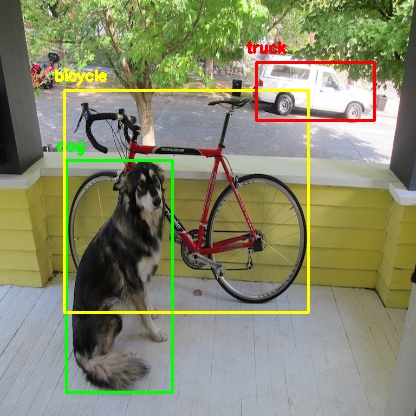

While in image classification, we only need to determine the class of an image, in object detection, however, we have to detect multiple objects, classify them, and locate where they are in the image. 

If a detector manages to locate an object in the image. It should output a rectangle that bound the object,  called bounding box. There are many way to represent a bounding box. The common way is that bounding box can be represented by a tuple (X,Y, h, w), where (X,Y) is the coordinate of center of the rectangle, and w, h are the width and height of the rectangle. At the same time, detector should also return predicted probabilities that object is one of the classes.

Because the detected model has two output: 

- the predicted probabilities

- bounding boxes

Therefore, we have two loss functions. One regression loss for bounding box, which we can choose $L2$ loss and one classification loss which we can choose  cross-entropy loss followed by softmax. Then we simply add two losses together and use gradient decent to find minimum. 







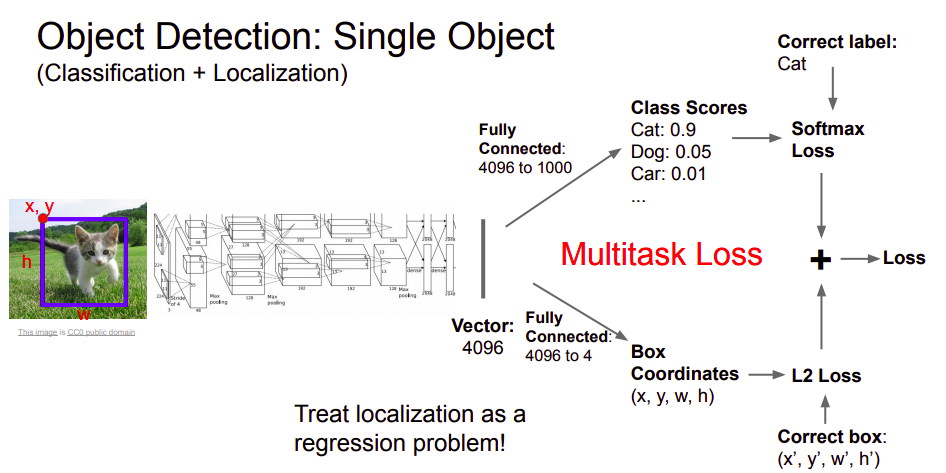

**Intersection over Union**: 

We have two bounding boxes that bound the object. One is the ground-truth box, this one done by human, and the predicted box returned by model. We need a way to measure how good the predicted box is. We can measure it by using value $IoU$ (Intersection over Union). By definition: 

$$ IoU := \frac{\text{Intersection of boxes}}{\text{Union of boxes}} $$

If $IoU$ is greater than 0.5, it is consider to be good. Usually, for an object there are many predicted bouding boxes, we calculate $IoU$ for all these boxes over ground-truth box and only retain the predicted box with the highest $IoU$. This technique is called non max suppression.

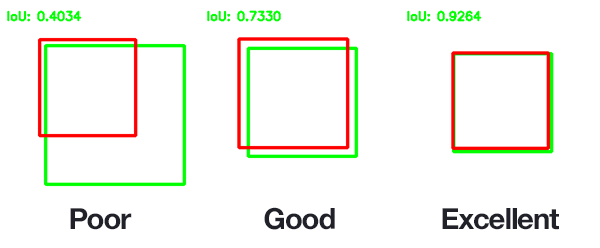

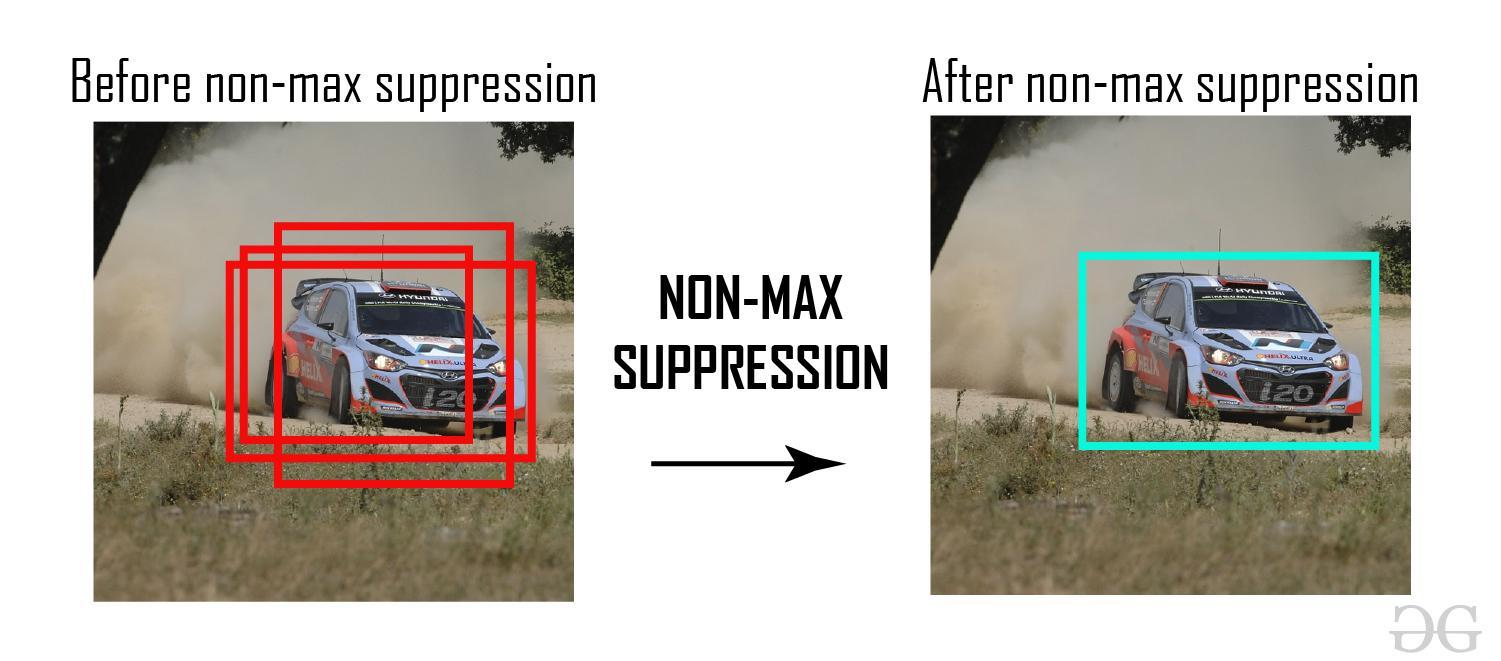

**Two stage vs one stage detectors**

In traditional computer vision people used the algo called sliding window for object detection. Basically, they use a predefined window with size smaller than image and sliding it all over image to detect object. For each region cover by sliding window they run CNN with two subnets for detection.




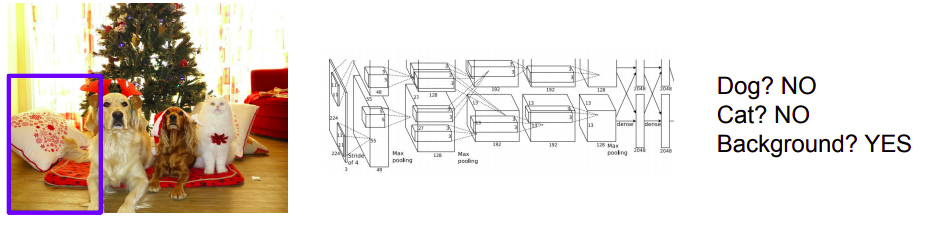

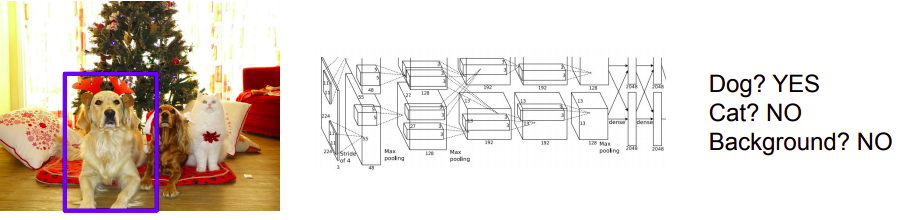

Usually, in an image there are multiple objects with different sizes. Therefore, we have to try many sliding window with a various size to detect them all and re-run the sliding algorithm over and over again. This results in a lot of computation.


Currently, there are two common type of detectors for object detection. They are one stage and two stage detectors. 

In two-stage detectors. The detection happens in two stages: (1) First, the model find “blobby” image regions that are likely to contain objects. (2) Then a classifier only processes the region candidates. 



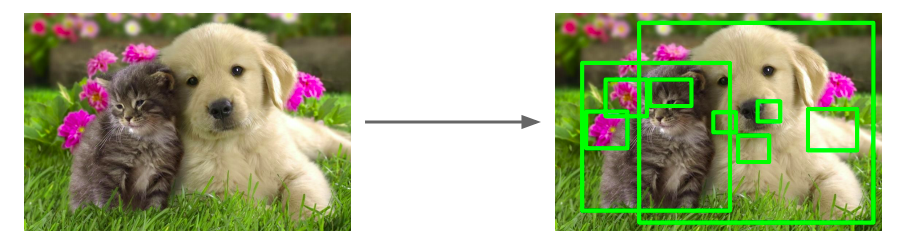

In one stage detection, the detector skips the region proposal stage and runs detection directly over a dense sampling of possible locations.
This makes one-stage faster and simpler, but less accurate than two stage detector.

RetinaNet is a one-stage object detection model that utilizes a focal loss function to address class imbalance during training, and thus make it has a comparable performance with two stage detectors.

We now focus on one stage detectors. 

The key idea in  one stage detector is that: **each bounding box detector is only responsible to a specific position in the image.This makes the detectors learn to specialize on objects in certain locations**


Let's say that after running CNN for an input image we get the feature map of width W and height H which is the output of the final layer. By nature of CNN, each  W $\times$ H locations of the feature map, correspond to some region in the input image.  

Now for each location in the feature map, we gonna put $N$ bounding boxes. These $N$ boxes will be responsible for the region in the input image that correspond to this location in feature map. 





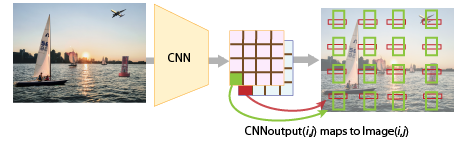

But why we put $N$ bounding boxes in every location of the feature map instead of just 1 bounding box. As mentioned, each location corresponds to a certain region in the input image. There may be multiple objects over this region. By putting $N$ boxed ($N$ is predefined), we can detect them all at once.

We can make this idea better by introducing the concept of anchor box.

**Anchor boxes**

Let's say we need to perform detection over the classes of person, car. After closely looking at the ground truth bounding box, it turns out that most bounding boxes have certain height-width ratios (aspect ratio). For example, bounding boxes for people tend to have height-width ratios is 2, height-width ratios is 1/3 for the car.

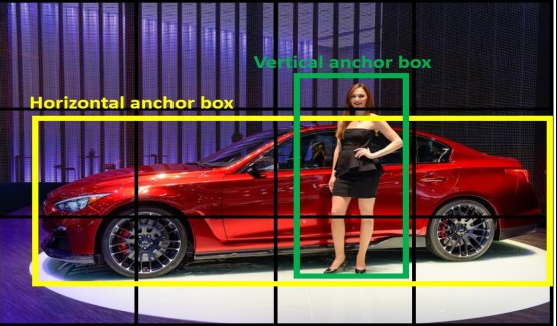

Anchor boxes or prior boxes are a set of predefined bounding boxes of a certain height and width. These boxes are defined to capture the scale and aspect ratio of specific object classes we want to detect. For example, anchors can be chosen by a k-means algorithm, by looking at all the bounding boxes in the dataset, then we can have the most k common shapes in the dataset.

This way of performing k-mean in dataset to get anchor boxes make the boxes dependent of the dataset. Sometimes, people want anchor boxes independent of the dataset, so they can use a mathematical formula to generate anchor boxes.

But how can anchor box help us ?


Now, instead of putting rather $N$ arbitrary bounding boxes over every location, we gonna put $N$ anchor boxes over every location in feature map. 

This makes sense because the anchor boxes are the $N$ most typical object shapes in the training set. So we have $N$ detectors each for an anchor box. By doing so, it can boost the performance. 





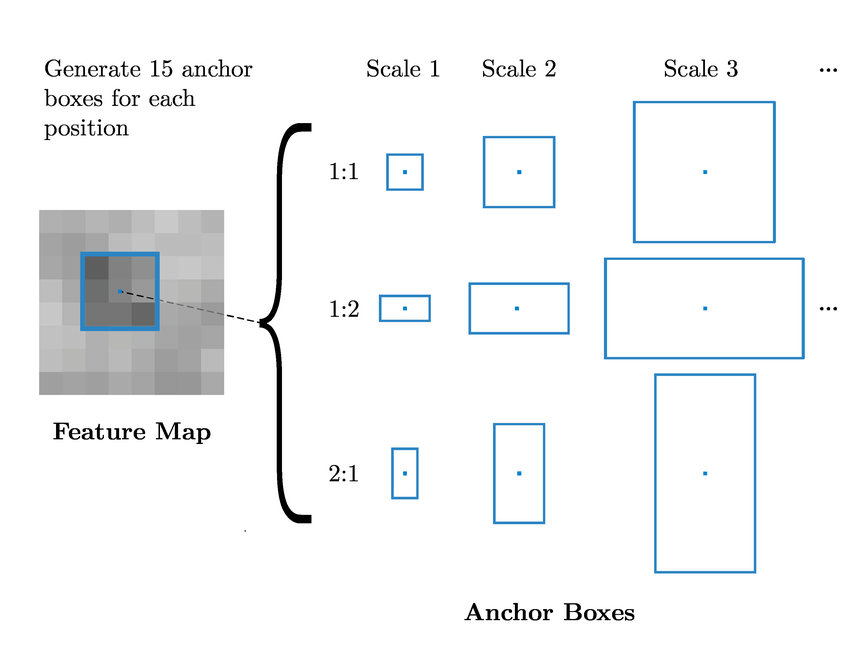

For example, with this picture, little square shaped object in the dataset can be detected by detector correspond to anchor box with similar shape, big rectangle with aspect ratio 1:2, can be detected by detector correspond to anchor box with similar shape, so on so forth.

**Matching Anchor boxed and ground-truth boxes** 

During detection anchor boxes are tiled across the image.


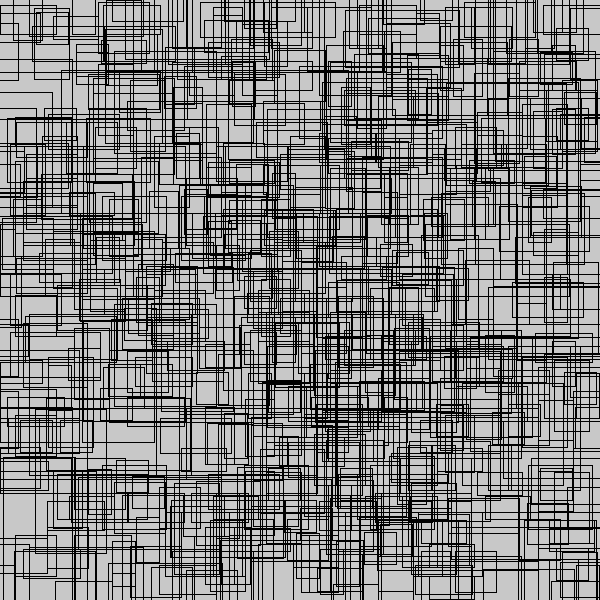

The network does not predict directly the predicted bounding box, it returns probabilities and offsets for every tiled anchor box. And matching the anchor boxed with ground-truth boxed by using $IoU$. 

Each anchor box has a one-to-one relationship with the bounding box prediction, so the match still can be thought as the match between predicted box and ground-truth. Depending on the value of $IoU$, we can have some conclusion like the box would contain background or foreground,..



## Focal loss

**Overview**

As mentioned, one stage detector is simpler, faster but less accurate than two stage detector. The authors discover that the extreme foreground-background class imbalance encountered during training of dense detectors is the central cause.

The main achievement of this paper is that it defines a novel loss that overcome this problem. This makes Retinanet as one stage detector is able to match the speed of previous one-stage detectors while surpassing the accuracy of all existing state-of-the-art two-stage detectors. They emphasize that their simple detector achieves top results not based on innovations in network design but due to their novel loss.




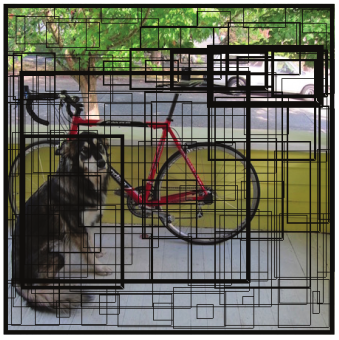

For example, in the above example only four bold bouding boxes are foreground (contain object), while the rest are background.


**Cross entropy**

Let say we have two distributions $\mathbf{p} = (p,1-p)$ and $\mathbf{q} = (q,1-q)$ . We can think of $\mathbf{p}$ as the ground-truth distribution and $\mathbf{q}$ as the predicted distribution. In order to measure the difference between $\mathbf{p}$ and $\mathbf{q}$ people use cross entropy and it is defined as follows: 

$$
CE(\mathbf{p},\mathbf{q})= -p \log (q)-(1-p) \log (1-q)
$$

The smaller $CE(\mathbf{p},\mathbf{q})$ is, the more $\mathbf{p}$ and $\mathbf{q}$ are "similar". For that reason, people can use cross entropy as the loss function.

Concretely, consider the binary classification case, without loss of generality, we can assume  $p = 1$. Therefore:
  $$CE(\mathbf{p},\mathbf{q}) = -\log \left(q\right)$$

So we can plot the value of cross entropy against $q$ as: 




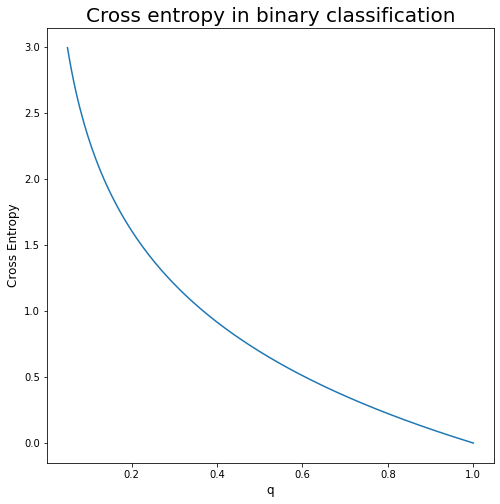

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

q = np.linspace(0.05, 1, 200)
d_ce = -np.log(q)

plt.figure(figsize=(8, 8))
plt.plot(q, d_ce)
plt.ylabel('Cross Entropy', fontsize=12)
plt.xlabel('q', fontsize=12)
plt.title('Cross entropy in binary classification', fontsize=20)
plt.show()

We easily see that cross entropy reach minimum = 0  when $q = 1$, that means in this case $p$ and $q$ are exactly the same.

In fact, in general if we differentiate $CE(\mathbf{p},\mathbf{q})$ with respect to $q$ and set to zero. We got:

$$
\frac{1-p}{1-q}=\frac{p}{q}
$$

Thus, $q = p$ mimimize the cross entropy

**Imbalanced data and balanced cross entropy**

From now on, for convenience, we will use the same notation as in the original paper. In the paper, they consider binary classification for illustration. 

Let $y$ is the ground truth and $p$ is the prediction of our model. The authors consider  $y \in\{\pm 1\}$. The reason is that it  makes some manipulation become nicer. But in this notebook, we do not consider those manipulation, and we think that  $y \in\{0, 1\}$ is more natural so we will stick with it. 


So the cross entropy can be rewritten as: 


$$
CE=-y \log (p)- (1-y) \log (1-p)
$$

Then, 

$$
CE=\left\{\begin{array}{ll}
-\log (p) & \text { if } y=1 \\
-\log (1-p) & \text { if } y = 0
\end{array}\right.
$$







But this actually causes us a problem. In the  scenario in which there is an extreme imbalance between foreground and background classes during
training (e.g., 1:1000, that means most of the instances are belongs to class 0). In this case, we mostly care about the correctness of model when predicting minority class, which is class 1 , (i.e detecting foreground). Using naive cross entropy  for imbalanced dataset will make our model doesn't predict well the minority class. 

One way to get around this problem is to give minority class more importance which can be done by introducing weight $\alpha$ and $1-\alpha$, for two classes. We modify cross entropy to the weight form as: 

$$
CE =-y \alpha \log (p)- (1-y)(1-\alpha) \log (1-p)
$$

In practice, we can choose $\alpha$ to be the inverse of class frequency, so that it will well balance out the disproportion of classes. Or $\alpha$ can be treated as hyperparameter for tunning. 





**Focal loss**

We can even improve weighted cross entropy  to get better loss function. In fact, this is the main achievement of the paper. By introducing a simple modification,  the authors manage to achieve a state-of-art for one stage object detection model. In the paper, they modified weighted cross entropy to a new loss called focal loss. They defined focal loss as: 

$$
FL:= -y\alpha(1-p)^{\gamma} \log (p)-(1-y)(1-\alpha) p^{\gamma} \log (1-p)
$$


So only factor $\left(1-p\right)^{\gamma}$ and $p^{\gamma}$ added. But it is very essential.

Let's see why it is useful

Again let us rewrite the definition of focal loss: 

$$
FL=\left\{\begin{array}{ll}
 -y\alpha(1-p)^{\gamma} \log (p)& \text { if } y=1 \\
 -(1-y)(1-\alpha) p^{\gamma} \log (1-p)& \text { if } y=0
\end{array}\right.
$$

We assume that the ground truth is $y = 1$, i.e the sample is foreground, and we know that $p$ be the inferred probability of the sample being as foreground from our model. Now there are two case:

- Given the ground truth is $y=1$, if $p$ is big aka $p$ is closed to 1. It can be interpreted as the model predict the sample likely being as foreground. So we say it is the easy case. Now because $p$ is closed to 1, then $1-p$ is close to 0 and $\left(1-p\right)^{\gamma}$ becomes a small value. Therefore, it doesn't not contribute much to the loss. 

- Given the ground truth is $y=1$, if $p$ is small, it can be interpreted as the model predict the sample likely not being as foreground. So we say it is the hard case. Now,
$1-p$ is close to 1 and $\left(1-p\right)^{\gamma}$ becomes a big value, so it contributes a great deal to the loss. Therefore, it makes the model learn harder in this hard case. Learning hard cases with focal loss thus make our model better.  

Just for things become even clearer. We do a simple comparasion. In easy case let say model return $p = 0.9$ and in hard case we got $p = 0.1$ and choosing $\gamma = 2$. Then the ratio of contributing to the loss function would be:

$$
\frac {\text{hard case}}{\text{easy case}} = \frac{(1-0.1)^{2}}{(1-0.9)^{2}}= 81
$$



And the ratio will be much bigger if the sample is a really hard case which is a good new !

In the paper, the authors find out that $\alpha = 0.25,\gamma = 2$ are the best parameters. 










**Deeper dive in to Focal Loss**


Most loss function are convex. Convexity is nice because local minimum is also global minimum. We would like to show focal loss is convex. 

$$
FL=\left\{\begin{array}{ll}
 -y\alpha(1-p)^{\gamma} \log (p)& \text { if } y=1 \\
 -(1-y)(1-\alpha) p^{\gamma} \log (1-p)& \text { if } y=0
\end{array}\right.
$$


We can use the second derivative test for convexity. All we need is prove that the second derivative is nonegative. Computing directly the second derivative and prove it nonegative is actually quite tedious for focal loss. But we still do it anyway. 


Now we process to prove that focal loss is convex. We only do for the case $y = 1$. The other case for $y =0$ is exactly the same. 

When $y = 1$, then 
$$
F L = -\alpha(1-p)^{\gamma} \log (p),
\\
0 < p, \alpha \leq 1, 0 \leq\gamma
$$

We fixed $\alpha = 1$ for simpler manipulation as it doesn't affect the convexity of focal loss. We have: 

$$
F L^{\prime}(p)=-(1-p)^{\gamma} \frac{1}{p}+\log (p) \cdot \gamma(1-p)^{\gamma-1}
$$

$$
F L^{\prime \prime}(p)=\frac{1}{p} \gamma(1-p)^{\gamma-1}+\frac{(1-p)^{\gamma}}{p^{2}}+\frac{1}{p} \gamma(1-p)^{\gamma-1} + -\log (p) \cdot \gamma(\gamma-1)(1-p)^{\gamma-2}
$$

If $1 \leq \gamma$ then all the terms in seconde derivative are nonegative so it is nonegative and focal loss is convex. Thus, we only care when $0 \leq \gamma\leq 1$. 

Continue, 

$$
F L^{\prime \prime}(p)=\frac{2 \gamma(1-\rho)^{\gamma-1}}{p}+\frac{(1-p)^{\gamma}}{p^2}-\log (p)\gamma(\gamma-1)(1-p)^{\gamma-2}
$$

$$
F L^{\prime\prime}(p) \geq 0 \Leftrightarrow \frac{2 \gamma(1-p)}{p}+\frac{(1-p)^{2}}{p^{2}}-\log (p) \gamma(\gamma-1) \geq 0
$$

Excluding the positive term we just need to show, 

$$
g(p)=\frac{2 \gamma(1-p)}{p}-\log (p) \gamma(\gamma-1) \geq 0
$$

$$
g^{\prime}(p)=\frac{-2 \gamma}{p^2}-\frac{1}{p} \gamma(\gamma-1)
$$

The idea is that we want to show $g$ is decreasing function. So, 

$$
\begin{aligned}
g^{\prime}(p)< 0 & \Leftrightarrow \frac{-2 \gamma}{p} \leq \gamma(\gamma-1) \\
& \Leftrightarrow \frac{-1}{p} \leqslant \frac{\gamma-1}{2}
\end{aligned}
$$
As $\gamma$ is in [0,1], taking the smallest $\gamma = 0$, so we just have to prove that: 

$-\frac{1}{p} \leq-0.5$ $\Leftrightarrow 0.5 p-1 \leq 0$. But it is obvious because $0\leq p\leq 1$. 

Therefore, $g(p)$ is deceasing function in [0,1] and thus, $g(p) \geq g(1) = 0$. Finally, that is the desired result we want to show,i.e the second derivative of focal loss is nonegative. So, focal loss is convex function.


















**Visualize Focal Loss and Conclusion**

We plot the focal loss with different $\gamma$ and fixed $\alpha = 1$

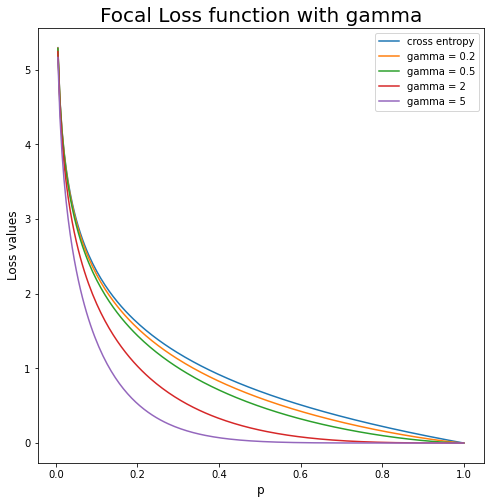

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 1
gammas = [0, 0.2, 0.5, 2, 5]
p = np.linspace(0, 1, 200)[1:]

def _focal_loss(p, gamma, alpha = 1):
  loss = (-(1-p)**gamma)* np.log(p)
  return loss

plt.figure(figsize=(8, 8))

for gamma in gammas:
  loss = _focal_loss(p, gamma = gamma)
  if gamma == 0:
    label = 'cross entropy'
  else:
    label = 'gamma = {}'.format(gamma)
  plt.plot(p, loss, label = label)

plt.title('Focal Loss function with gamma', fontsize=20)
plt.xlabel('p', fontsize=12)
plt.ylabel('Loss values', fontsize=12)
plt.legend()
plt.show()

When $\gamma = 0$ focal loss becomes weight cross entropy. As can be seen from the graph above, these examples corressponding to the easy case, i.e the ones with high value $p$, contribute very little to the loss. By using focal loss, we tell our model focus mostly for the hard case during training. 

Finally, we would like to make a conclusion of focal loss:



*   **firstly, it values the "precious" foreground by giving this class more importance through $\alpha$ factor**
*   **secondly, within the the "precious" foreground it values also the hard case during the traing through factor $\left(1-p\right)^{\gamma}$**
  
*  **Finally, focal loss is convex function so in practice we can actually find global minimum by using gradient descent**   



**Calculating derivative of Focal Loss according to the paper**

We note here that in the orginal paper they use sigmoid function to compute the predicted probability $p$: 

$$
p=\frac{1}{1+e^{-x}}
$$

Our formula for $FL$ loss above is quite tedious. In order to simplify notation they use two artificial variables: 

$$
p_{t}=\left\{\begin{array}{ll}
p & \text { if } y=1 \\
1-p & \text { otherwise }
\end{array}\right.
$$

$$
\alpha_{t}=\left\{\begin{array}{ll}
\alpha & \text { if } y=1 \\
1-\alpha & \text { otherwise }
\end{array}\right.
$$

They are just two artificial variable. Nothing more. Therefore, focal loss can be written as: 

$$
FL=-\alpha_{t}\left(1-p_{t}\right)^{\gamma} \log \left(p_{t}\right)
$$

Now we want calculate derivative of focal loss with respect to $x$. We fix $\alpha_t = 1$

By chain rule, we have: 

$$
\frac{\partial F L}{\partial x}=\frac{\partial F L}{\partial p_{t}} \times \frac{\partial p_{t}}{\partial p} \times \frac{\partial p}{\partial x}
$$

As we have computed before: 

$$
FL^{\prime}(p)=-(1-p)^{\gamma} \frac{1}{p}+\log (p) \cdot \gamma(1-p)^{\gamma-1}
$$

This time only substitude $p$ with $p_t$, we got: 

$$
FL^{\prime}(p_t)=\alpha_{t}\left(1-p_{t}\right)^{\gamma}\left(\frac{\left.\gamma p_{t} \log \left(p_{t}\right)+p_{t}-1\right)}{p_{t}\left(1-p_{t}\right)}\right)
$$

We also have: 

$$p_t = py +(1-p)(1-y)$$

so, 

$$
\frac{\partial p_{t}}{\partial p}= 2y-1
$$

Applying formula for derivative of sigmoid: 

$$
\frac{\partial p}{\partial x}=p(1-p)
$$

Finally, 

$$
\frac{\partial FL}{\partial x}=\left(1-p_{t}\right)^{\gamma}\left(\frac{\left.\gamma p_{t} \log \left(p_{t}\right)+p_{t}-1\right)}{p_{t}\left(1-p_{t}\right)}\right) \times (2y-1) \times p\left(1-p\right)
$$

No matter what $y$ is we always have:
$p(1-p) = p_t(1-p_t) $, then two term get cancel out. Therefore,

$$\frac{\partial FL}{\partial x}= (2y-1)\left(1-p_{t}\right)^{\gamma}\left(\gamma p_{t} \log \left(p_{t}\right)+p_{t}-1\right)
$$

Comparing with the derivative authors provided in the appendix of paper:


$$
\frac{\partial FL}{\partial x}=y\left(1-p_{\mathrm{t}}\right)^{\gamma}\left(\gamma p_{\mathrm{t}} \log \left(p_{\mathrm{t}}\right)+p_{\mathrm{t}}-1\right)
$$

We notice that only factor $y$ and $2y-1$ is different. That's because we consider $y \in \{ 1,0\}$ instead of $\{1,-1\}$.







## Part 2 Architecture of retinanet

RetinaNet is a single, unified network composed of a
backbone network and two task-specific subnetworks. The
backbone is responsible for computing a convolutional feature map over an entire input image and is an off-the-self
convolutional network. The first subnet performs convolutional object classification on the backbone’s output; the
second subnet performs convolutional bounding box regression



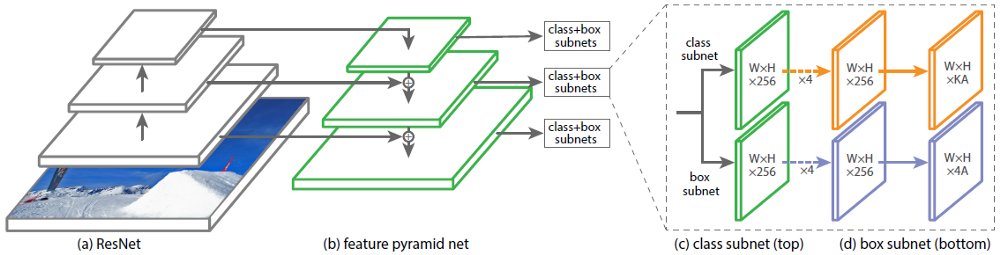


Now we will see more closely each component of retinanet

**Backbone**

Backbone of Retinanet consist of ResNet and Feature Pyramid Network (FPN) where Resnet is reponsible for deep feature extraction. The authors also adopt the Feature Pyramid Network (FPN) from their paper in 2017 as for RetinaNet. 

We would like to say few words to Feature Pyramid Network. 

An image worths thousand words. First, we will look at the picture to get the general idea of FPN. 



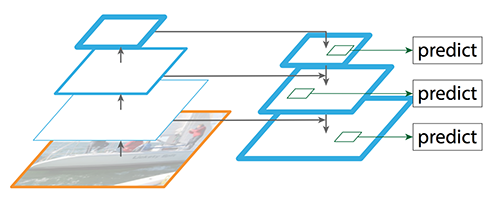





FPN composes of a bottom-up and a top-down pathway. The bottom-up ( the left one in the picture) pathway is the usual convolutional network for feature extraction. Input of bottom-up pathway is the original image,  by nature of convolution, as we go up the size of image get smaller and smaller but at the same time it represent stronger and stronger feature, i.e semantic value for each layer increases. In short, layers with big size contain weak features, and layers with small size contain strong features. 

For certains detectors, they have only the bottom-up pathway and they makes prediction along the way while going up as:  



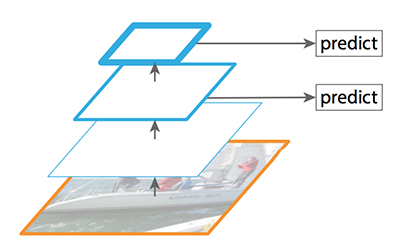

Notice that for those kind of detectors, only the upper layers are used, because the lowers layer contain very weak feature. Imagine that if we have a small object needed to detect, the upper layers now becomes very small and that makes the performance on small object is much worse. 

In order to resolve the trade-off between big / small resolution and weak/ strong feature. FPN comes up with  a top-down pathway to combine bigger size layers with a strong-feature layer. FPN uses lateral connections for connecting two pathways. We will see lateral connections soon.

**Bottom-up pathway**:

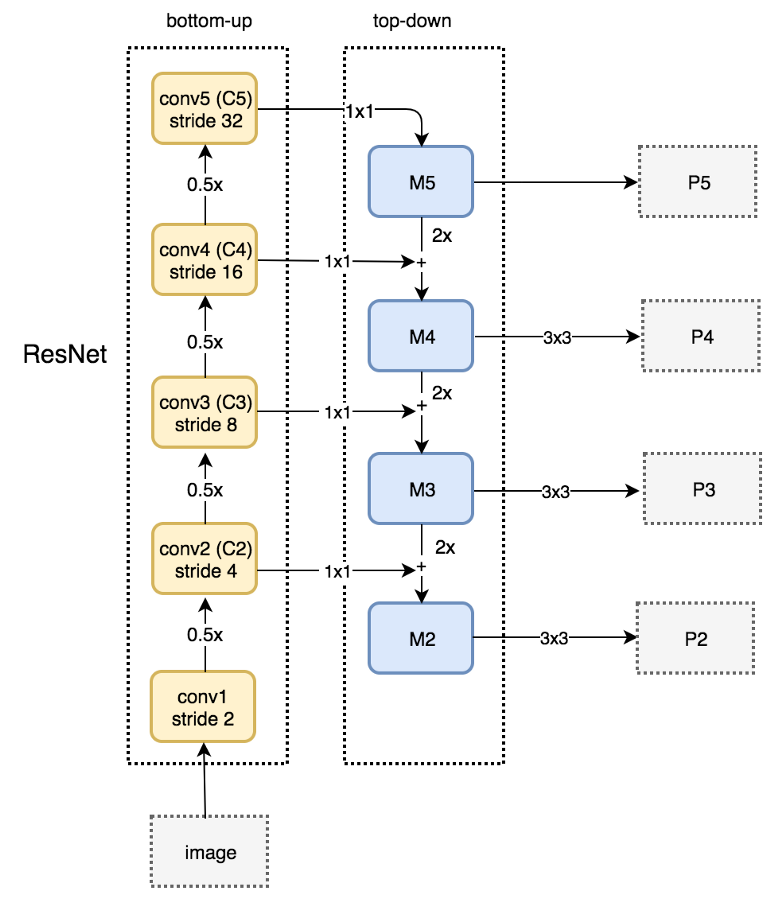

Retinanet uses ResNet to construct the bottom-up pathway. It composes of many convolution modules (conv i for i equals 1 to 5) each has many convolution layers. As we move up, the spatial dimension is reduced by 1/2 (i.e. double the stride). The output of each convolution module is labeled as Ci and later used in the top-down pathway for merging.

**Top-down pathway**: 

Retinanet applys a 1 × 1 convolution filter to reduce C5 channel depth to 256-d to create M5. This becomes the first feature map layer used for object prediction.

As we go down the top-down path, we upsample the previous layer by 2 using nearest neighbors upsampling. We again apply a 1 × 1 convolution to the corresponding feature maps in the bottom-up pathway. Then we add them element-wise. We apply a 3 × 3 convolution to all merged layers. 

We repeat the same process for P3 and P2. However, we stop at P2 because the spatial dimension of C1 is too large. Otherwise, it will slow down the process too much. Because we share the same classifier and box regressor of every output feature maps, all pyramid feature maps (P5, P4, P3 and P2) have 256-d output channels.

**lateral connection**: the way described above: upsampling + applying 1 × 1 convolution filter and adding them together is exactly lateral connection. The picture below  illustrating the lateral connection: 



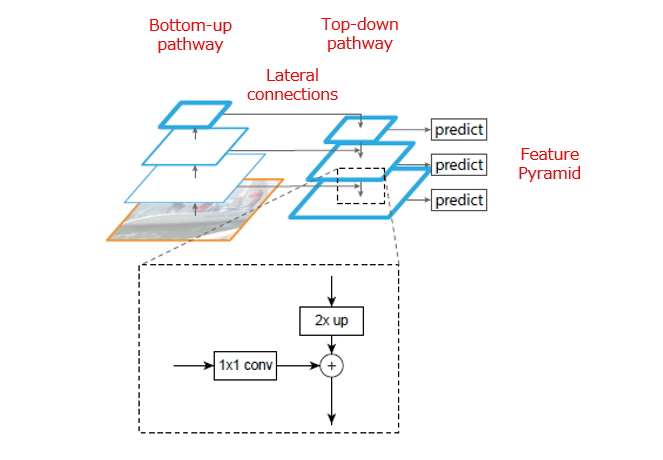

**Two subnet: Classification and Regression**

As mentioned in the beginning, in detection model we have to predict classes and bounding boxes. Therefore two subnets (two head) will be needed for that. 

**The classification subnet:**
is a small FCN attached to each FPN level; parameters of
this subnet are shared across all pyramid levels. Its design
is simple. Taking an input feature map with C channels
from a given pyramid level, the subnet applies four 3×3
conv layers, each with C filters and each followed by ReLU
activations, followed by a 3×3 conv layer with  K $\times$ A filters followed by sigmoid activation. So the shape of the output feature map would be (W, H, K $\times$ A). We note here that K is the number of class and A is number of anchor box. 

**Regression subnet:** In parallel with the object classification subnet, we attach another small FCN  to each feature map of the FPN. The design of the regression subnet is identical to that of the classification subnet, and thus the width and height of output feature map is still W and H as in classification subnet. But now, the number of channels in the output is 4$\times$ K. 





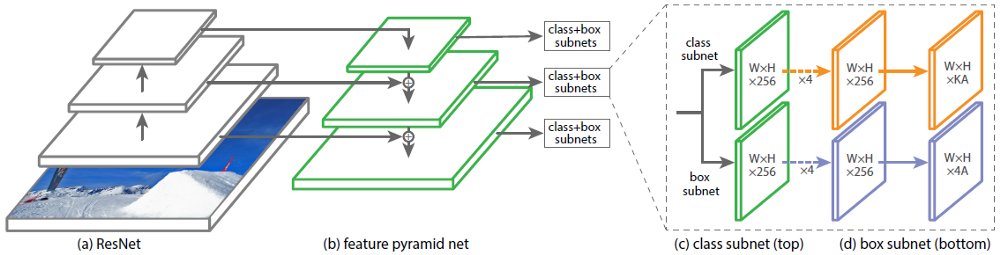

We will explain why the number of channels in two subnets are different. 

Recall that the role of anchor in the review of detection, is that we want to set constraint on the shape of object that detector would detect. 

In classification subnet, each anchor box is reponsible for detecting object from $K$
classes in the area that it covers. So each detector correspond to anchor boxes will return a $K$ tuple predicted probabilities. As we put $A$ anchor boxes for each location, so the number of channels is $K \times A$. 

In regression subnet, each detector will return $4$-tuple (X,Y,h,w) for center's coordinate, width and height. As we put $A$ anchor boxes for each location, so the number of channels is $4 \times A$. 

In the paper, the author use $A =9$ anchor boxed over each location.


So, we summarize what authors did for anchor in the paper:

- The anchors have the shape of $32 \times 32 $ to $512 \times 512$ on pyramid levels from P3 to P7 respectively.

- Three aspect ratios {1:2, 1:1, 2:1} are used

- For denser scale coverage, anchors of sizes $\{2^0, 2^{1/3}, 2^{2/3}\}$ are added at each pyramid level.

- 9 anchors per locaion.

- Anchors are assigned to ground-truth object boxes using an intersection-over-union (IoU) threshold of 0.5; and to background if their $IoU$ is in [0, 0.4)

- If an anchor is unassigned, which may happen with overlap
in [0.4, 0.5), it is ignored during training

## Pretrained Retinanet Model in Pytorch

There are many good implementation of Retinanet in internet. For example [keras implementation](https://github.com/fizyr/keras-retinanet), [Pytorch implementation](https://github.com/yhenon/pytorch-retinanet), or [keras tutorial ](https://keras.io/examples/vision/retinanet/). For this notebook, we gonna use pretrained retinanet_resnet50_fpn model in Coco dataset of pytorch. 

The model has been already trained on many images. So we just need to use this for new image. If you use colab to run this notebook, no need to install anything as colab comes with everything preinstalled. Otherwise, need to install opencv, torch,..

If you use colab then first thing to do is mount to google drive so it can connect to your drive. 

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


This is the classes from Coco dataset.  

In [ ]:
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Now upload a random image that contain objects belonging to the classes of Coco dataset to your google drive. Because we have mounted to google drive so we can get the path of the image. For example, after uploading image named dogandperson.jpg to google drive, I get the path of the image as: 



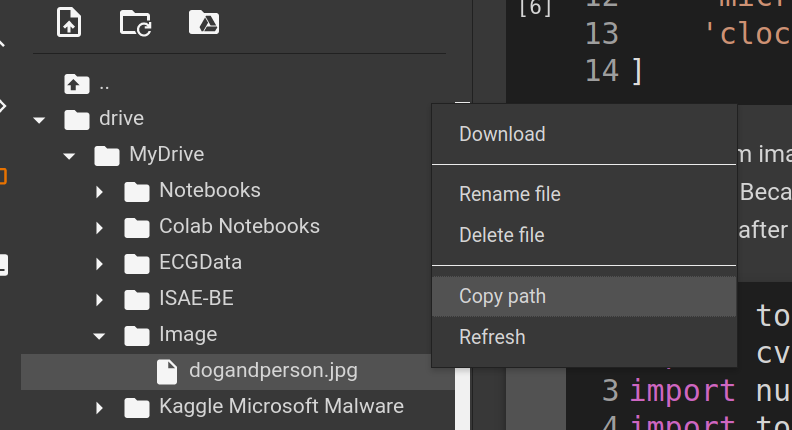

This is the picture

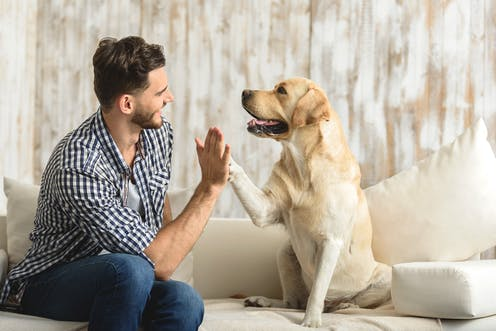

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import numpy as np
from PIL import Image

In [ ]:
# create different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

def predict(image, model, device, detection_threshold):
    # transform the image to tensor
    image = transform(image).to(device)
    image = image.unsqueeze(0) # add a batch dimension
    with torch.no_grad():
        outputs = model(image)

    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > detection_threshold]
    bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    boxes = bboxes[np.array(scores) >= detection_threshold].astype(np.int32)
    labels = outputs[0]['labels'].cpu().numpy()
    pred_classes = [coco_names[labels[i]] for i in thresholded_preds_inidices]
    return boxes, pred_classes

#function to draw a box
def draw_boxes(boxes, classes, image):
    for i, box in enumerate(boxes):
        color = COLORS[coco_names.index(classes[i])]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1]-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, 
                    lineType=cv2.LINE_AA)
    return image

In [ ]:
#load pretrained model
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the model into device
model.eval().to(device)

#pass the path of image 
image = Image.open("/content/drive/MyDrive/Image/dogandperson.jpg").convert('RGB')

image_array = np.array(image)

# convert to OpenCV BGR color format
image_array = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)


boxes, classes = predict(image, model, device, 0.6)

result = draw_boxes(boxes, classes, image_array)


cv2.waitKey(0)
save_name = "detected_image"
#set the path to save output image
cv2.imwrite(f"/content/{save_name}.jpg", result)

True

Note here that we choose confidence score is 0.6 as threshold. This score reflects how likely model think the box contain object. The image result is:


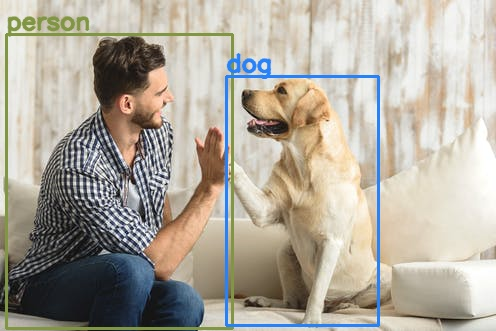

## Reference

- https://arxiv.org/pdf/1708.02002.pdf
- https://arxiv.org/pdf/1612.03144.pdf
- https://pytorch.org/docs/stable/_modules/torchvision/models/detection/retinanet.html#retinanet_resnet50_fpn
- http://cs231n.stanford.edu/slides/2020/lecture_12.pdf
- https://fr.mathworks.com/help/vision/ug/anchor-boxes-for-object-detection.html
- https://jonathan-hui.medium.com/understanding-feature-pyramid-networks-for-object-detection-fpn-45b227b9106c
- https://leimao.github.io/blog/Focal-Loss-Explained/
- https://blog.zenggyu.com/en/post/2018-12-05/retinanet-explained-and-demystified/#fnref10
- https://medium.com/@14prakash/the-intuition-behind-retinanet-eb636755607d

- https://towardsdatascience.com/anchor-boxes-the-key-to-quality-object-detection-ddf9d612d4f9